뉴 스파크인지 이진분류 실험 -> 실패

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm import tqdm
import timm
from torchsummaryX import summary
from sklearn.model_selection import train_test_split, StratifiedKFold

from torch.utils.data import Dataset
from torch import nn

## Config

In [2]:
from dotenv import load_dotenv
from setup import get_package_root_path
from src.global_exception_handler.v1 import GlobalExceptionHandler
from src.webhook.v1 import TeamsWebhook

load_dotenv()

pakage_name = os.environ.get("PACKAGE_NAME")
root_path = get_package_root_path()

# 웹훅 알림 url (없으면 빈 문자열)
webhook_url = os.environ.get("WEBHOOK_URL")
webhook = TeamsWebhook(webhook_url)

# 핸들링할 예외 종류
except_tuple = (Exception,)
GlobalExceptionHandler(except_tuple=except_tuple, sender=webhook, name="dacon_cars")

In [3]:
!nvidia-smi

Wed Jun 14 19:12:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:81:00.0 Off |                  Off |
| 30%   36C    P8    20W / 300W |   2273MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameter Setting

In [12]:
class CFG:
    root_path = root_path
    # Job Id (보통 파일명과 동일하게)
    job_id = "CLASSICIATION_4"

    # 원천 데이터 경로
    data_path = f"{root_path}/data/cars"

    # 학습의 결과물이 저장될 경로
    outputs_path = f"{root_path}/outputs/{job_id}"
    predict_dir = f"{outputs_path}/predict"
    recorder_dir = f"{outputs_path}/recorder"

    learning_late = 0.001
    batch_size = 64
    epoch = 50
    num_classes = 2

    classes = [
        "chevrolet_malibu_sedan_2012_2016",
        "chevrolet_malibu_sedan_2017_2019",
        "chevrolet_spark_hatchback_2016_2021",
        "chevrolet_trailblazer_suv_2021_",
        "chevrolet_trax_suv_2017_2019",
        "genesis_g80_sedan_2016_2020",
        "genesis_g80_sedan_2021_",
        "genesis_gv80_suv_2020_",
        "hyundai_avante_sedan_2011_2015",
        "hyundai_avante_sedan_2020_",
        "hyundai_grandeur_sedan_2011_2016",
        "hyundai_grandstarex_van_2018_2020",
        "hyundai_ioniq_hatchback_2016_2019",
        "hyundai_sonata_sedan_2004_2009",
        "hyundai_sonata_sedan_2010_2014",
        "hyundai_sonata_sedan_2019_2020",
        "kia_carnival_van_2015_2020",
        "kia_carnival_van_2021_",
        "kia_k5_sedan_2010_2015",
        "kia_k5_sedan_2020_",
        "kia_k7_sedan_2016_2020",
        "kia_mohave_suv_2020_",
        "kia_morning_hatchback_2004_2010",
        "kia_morning_hatchback_2011_2016",
        "kia_ray_hatchback_2012_2017",
        "kia_sorrento_suv_2015_2019",
        "kia_sorrento_suv_2020_",
        "kia_soul_suv_2014_2018",
        "kia_sportage_suv_2016_2020",
        "kia_stonic_suv_2017_2019",
        "renault_sm3_sedan_2015_2018",
        "renault_xm3_suv_2020_",
        "ssangyong_korando_suv_2019_2020",
        "ssangyong_tivoli_suv_2016_2020",
    ]


CFG.__dict__

mappingproxy({'__module__': '__main__',
              'root_path': '/data/dacon_cars',
              'job_id': 'CLASSICIATION_4',
              'data_path': '/data/dacon_cars/data/cars',
              'outputs_path': '/data/dacon_cars/outputs/CLASSICIATION_4',
              'predict_dir': '/data/dacon_cars/outputs/CLASSICIATION_4/predict',
              'recorder_dir': '/data/dacon_cars/outputs/CLASSICIATION_4/recorder',
              'learning_late': 0.001,
              'batch_size': 64,
              'epoch': 50,
              'num_classes': 2,
              'classes': ['chevrolet_malibu_sedan_2012_2016',
               'chevrolet_malibu_sedan_2017_2019',
               'chevrolet_spark_hatchback_2016_2021',
               'chevrolet_trailblazer_suv_2021_',
               'chevrolet_trax_suv_2017_2019',
               'genesis_g80_sedan_2016_2020',
               'genesis_g80_sedan_2021_',
               'genesis_gv80_suv_2020_',
               'hyundai_avante_sedan_2011_2015',
    

## CustomDataset

In [5]:
from sklearn.utils.class_weight import compute_class_weight


class CustomDataset(Dataset):
    def __init__(self, X, y, transforms=None, num_classes: int = None):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.num_classes = num_classes

    def to_categorical(self, y, num_classes):
        """1-hot encodes a tensor"""
        return np.eye(num_classes, dtype="uint8")[y]

    def get_class_weight(self):
        return torch.Tensor(
            compute_class_weight(
                class_weight="balanced", classes=np.unique(self.y), y=self.y
            )
        )

    def __getitem__(self, index):
        img_path = self.X[index]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        image = image[int(image.shape[0] / 2) :]

        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        if self.y is None:  # if test
            return image, img_path

        # train or valid
        label = self.y[index]
        if self.num_classes is None:
            return image, label, img_path
        else:
            return image, self.to_categorical(label, self.num_classes), img_path

    def __len__(self):
        return len(self.X)

## Transforms

In [6]:
train_transform = A.Compose(
    [
        A.Resize(
            224,
            224,
        ),
        A.ShiftScaleRotate(
            scale_limit=0.01,
            rotate_limit=5,
            p=0.9,
            border_mode=0,
            value=(0, 0, 0),
        ),
        A.ToGray(p=1),
        A.HorizontalFlip(),
        A.Equalize(by_channels=False),
        A.ElasticTransform(
            p=0.5,
            alpha=0.20000000298023224,
            sigma=3.359999895095825,
            alpha_affine=2.009999990463257,
            interpolation=1,
            border_mode=0,
            value=(0, 0, 0),
            mask_value=None,
            approximate=False,
        ),
        A.GaussNoise(p=0.5, var_limit=(20, 40)),
        A.HueSaturationValue(),
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1),
        A.OneOf(
            [
                A.CoarseDropout(fill_value=255, max_height=12, max_width=12),
                A.CoarseDropout(fill_value=128, max_height=12, max_width=12),
                A.CoarseDropout(fill_value=0, max_height=12, max_width=12),
            ],
            p=1,
        ),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.ToGray(p=1),
        A.Equalize(by_channels=False),
        # A.GaussianBlur(blur_limit=(3, 21), p=1),
        # A.HueSaturationValue(),
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

## Init dataset

In [13]:
data = None
for i, cls in enumerate(range(len(CFG.classes))):
    data_path_list = sorted(glob(f"{CFG.data_path}/{cls}/*.png"))
    data_path_list = np.expand_dims(np.array(data_path_list), 1)

    if cls == 2:
        labels = np.ones(data_path_list.shape, dtype=np.uint8)
    else:
        labels = np.zeros(data_path_list.shape, dtype=np.uint8)

    temp = np.concatenate([data_path_list, labels], axis=1)

    data = temp if data is None else np.concatenate([data, temp], axis=0)

In [14]:
df = pd.DataFrame(data)
df.columns = ["path", "label"]
df = df.astype({"path": "string", "label": "int"})
df[500:]

,path,label
500,/data/dacon_cars/data/cars/1/syn_00006_2.png,0
501,/data/dacon_cars/data/cars/1/syn_00026_0.png,0
502,/data/dacon_cars/data/cars/1/syn_00032_1.png,0
503,/data/dacon_cars/data/cars/1/syn_00064_1.png,0
504,/data/dacon_cars/data/cars/1/syn_00074_2.png,0
...,...,...
16995,/data/dacon_cars/data/cars/33/syn_06341_0.png,0
16996,/data/dacon_cars/data/cars/33/syn_06347_0.png,0
16997,/data/dacon_cars/data/cars/33/syn_06434_2.png,0
16998,/data/dacon_cars/data/cars/33/syn_06437_0.png,0


In [15]:
for i, cls in enumerate(range(CFG.num_classes)):
    print(f'{cls} : {df[df["label"] == i].shape[0]}')

print("")
print(f"전체 : {df.shape[0]}")

0 : 16500
1 : 500

전체 : 17000


## Train / Validation Split

In [16]:
data_fold_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
checker = data_fold_splitter.get_n_splits(X=df, y=df["label"])
print(checker)

5


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score


def save_pred(saved_path, path, y_true, y_pred, y_prob=None):
    os.makedirs(saved_path)

    df_data = [path, y_true, y_pred]
    df_columns = ["path", "y_true", "y_pred"]

    if y_prob != None:
        df_data.append(y_prob)
        df_columns.append("y_prob")

    df = pd.DataFrame(np.array(df_data).T)
    df.columns = df_columns

    df.to_csv(f"{saved_path}/pred.csv", index=False)

    ### 임시 confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.set(rc={"figure.figsize": (21, 21)})
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    _val_score = f1_score(y_true, y_pred, average="macro")
    plt.xlabel(f"Pred / F1-score: {_val_score:.3f}")
    plt.ylabel("Real")

    classes_point = list(map(lambda x: x + 0.5, range(CFG.num_classes)))
    classes = list(range(CFG.num_classes))
    plt.xticks(classes_point, classes)
    plt.yticks(classes_point, classes)
    plt.savefig(f"{saved_path}/c_matrix.jpg")
    plt.clf()

## Valid

In [18]:
from src.image_eda.v1 import tensor2im
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    confusion_matrix,
)


def valid(model, criterion, data_loader, device):
    model.eval()
    val_loss = []

    epoch_paths = []
    y_true = []
    y_pred = []
    # y_probs = []
    with torch.no_grad():
        for batch_index, (images, labels, paths) in enumerate(tqdm(data_loader)):
            if batch_index % 10 == 0:
                temp_img = images[0].detach()
                temp_img = tensor2im(temp_img)

                cv2.imwrite(f"{CFG.root_path}/temp/valid_img.jpg", temp_img)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            probs = model(images)
            loss = criterion(probs, labels)

            probs = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            preds = np.argmax(probs, 1).astype(np.uint8)
            labels = np.argmax(labels, 1).astype(np.uint8)

            preds = preds.flatten()
            labels = labels.flatten()

            y_pred += preds.tolist()
            y_true += labels.tolist()
            # y_probs += probs.tolist()
            epoch_paths += paths

            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_score = accuracy_score(y_true, y_pred)

    return {
        "val_loss": val_loss,
        "val_score": val_score,
        "path": epoch_paths,
        "y_true": y_true,
        "y_pred": y_pred,
    }

## Train

In [19]:
# def cutmix(batch, alpha=1.0):
#     data, targets = batch

#     indices = torch.randperm(data.size(0))
#     shuffled_data = data[indices]
#     shuffled_targets = targets[indices]

#     lam = np.random.beta(alpha, alpha)

#     image_h, image_w = data.shape[2:]
#     cx = np.random.uniform(0, image_w)
#     cy = np.random.uniform(0, image_h)
#     w = image_w * np.sqrt(1 - lam)
#     h = image_h * np.sqrt(1 - lam)
#     x0 = int(np.round(max(cx - w / 2, 0)))
#     x1 = int(np.round(min(cx + w / 2, image_w)))
#     y0 = int(np.round(max(cy - h / 2, 0)))
#     y1 = int(np.round(min(cy + h / 2, image_h)))

#     data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
#     targets = (targets, shuffled_targets, lam)

#     return data, targets

In [20]:
# from src.my_loss.v1 import FocalLoss


# class CutMixCriterion:
#     def __init__(self):
#         self.criterion = FocalLoss()

#     def __call__(self, preds, targets):
#         targets1, targets2, lam = targets
#         return lam * self.criterion(preds, targets1) + (1 - lam) * self.criterion(
#             preds, targets2
#         )

In [21]:
def train(model, criterion, optimizer, data_loader, device, grad_scaler=None):
    model.train()
    train_loss = []

    epoch_paths = []
    y_true = []
    y_pred = []
    for batch_index, (images, labels, paths) in enumerate(tqdm(data_loader)):
        # images, labels = cutmix(
        #     (images, labels),
        # )

        if batch_index % 10 == 0:
            temp_img = images[0].detach()
            temp_img = tensor2im(temp_img)

            cv2.imwrite(f"{CFG.root_path}/temp/train_img.jpg", temp_img)

        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        # labels = (
        #     labels[0].to(device, dtype=torch.float),
        #     labels[1].to(device, dtype=torch.float),
        #     labels[2],
        # )

        optimizer.zero_grad()
        if grad_scaler is None:
            probs = model(images)
            loss = criterion(probs, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                probs = model(images)
                loss = criterion(probs, labels)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

        probs = probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        preds = np.argmax(probs, 1).astype(np.uint8)
        labels = np.argmax(labels, 1).astype(np.uint8)

        preds = preds.flatten()
        labels = labels.flatten()

        y_pred += preds.tolist()
        y_true += labels.tolist()
        epoch_paths += paths

        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_score = accuracy_score(y_true, y_pred)

    return {
        "train_loss": train_loss,
        "train_score": train_score,
    }

## Model Define

In [22]:
def create_model(num_classes: int) -> nn.Module:
    # model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.DEFAULT)
    # model.classifier = nn.Sequential(nn.Linear(2048, num_classes), nn.Softmax())

    # model = timm.models.eva.eva02_large_patch14_448(pretrained=True)
    # model.head = nn.Sequential(
    #     nn.Linear(1024, 768),
    #     nn.BatchNorm1d(768),
    #     nn.SiLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(768, 384),
    #     nn.BatchNorm1d(384),
    #     nn.SiLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(384, num_classes),
    # )

    model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(1280, num_classes)

    # model = timm.models.convnext.convnext_large_mlp(pretrained=True)
    # model.head.fc = nn.Sequential(
    #     nn.Linear(1024, 768),
    #     nn.LayerNorm(768),
    #     nn.SiLU(),
    #     nn.Dropout(0.5),
    #     nn.Linear(768, num_classes),
    # )

    return model


# create_model(34)

## Snapshot Notebook

In [23]:
import shutil

try:
    import IPython

    notebook_path = IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
except:
    notebook_path = f"{os.getcwd()}/{CFG.job_id}.ipynb"


os.makedirs(CFG.outputs_path, exist_ok=True)
shutil.copy(notebook_path, f"{CFG.outputs_path}/{os.path.split(notebook_path)[1]}")

'/data/dacon_cars/outputs/CLASSICIATION_4/CLASSICIATION_4.ipynb'

## Run!!

In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [25]:
from src.random_seed.v1 import seed_everything, seed_worker

seed_everything(0)

In [26]:
grad_scaler = torch.cuda.amp.GradScaler()

In [27]:
from src.recorder.v1 import Recorder
from src.my_loss.v1 import FocalLoss
from time import time


for fold_index, (train_idx, valid_idx) in enumerate(
    data_fold_splitter.split(X=df, y=df["label"])
):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[valid_idx]

    train_dataset = CustomDataset(
        train_df["path"].values,
        train_df["label"].values,
        train_transform,
        CFG.num_classes,
    )
    num_workers = 64
    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=num_workers,  #
        pin_memory=True,
        drop_last=False,
        worker_init_fn=seed_worker,
    )
    #
    val_dataset = CustomDataset(
        val_df["path"].values, val_df["label"].values, val_transform, CFG.num_classes
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        worker_init_fn=seed_worker,
    )
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG.learning_late)
    scheduler = None

    recorder = Recorder(
        f"{CFG.recorder_dir}/fold_{fold_index}", model, optimizer, scheduler
    )
    print(f"fold_{fold_index} start")
    if recorder.load_checkpoint(device, "checkpoint.pt"):
        print(f"loaded current_epoch: {recorder.current_epoch}")

    criterion = FocalLoss()

    best_val_loss = 100
    for epoch_index in range(recorder.current_epoch, CFG.epoch):
        seed_everything(epoch_index)

        train_start_timestamp = time()
        train_dict = train(
            model, criterion, optimizer, train_loader, device, grad_scaler
        )
        train_elapsed_time = time() - train_start_timestamp

        val_start_timestamp = time()
        val_dict = valid(model, criterion, val_loader, device)
        val_elapsed_time = time() - val_start_timestamp

        recorder.update_row_dict("epoch", epoch_index + 1)

        recorder.update_row_dict("train_loss", train_dict["train_loss"])
        recorder.update_row_dict("val_loss", val_dict["val_loss"])

        recorder.update_row_dict("train_score", train_dict["train_score"])
        recorder.update_row_dict("val_score", val_dict["val_score"])

        recorder.update_row_dict("train_elapsed_time", train_elapsed_time)
        recorder.update_row_dict("val_elapsed_time", val_elapsed_time)
        recorder.flush_row_dict(is_print=True)
        recorder.save_line_plot(["loss"], [0, 1])

        save_pred(
            f"{CFG.predict_dir}/fold_{fold_index}/{epoch_index}",
            val_dict["path"],
            val_dict["y_true"],
            val_dict["y_pred"],
        )

        if recorder.is_best_score(val_dict["val_loss"], "min"):
            print(f"best epoch: {epoch_index + 1}")
            recorder.save_checkpoint(epoch_index, "best_model.pt")

        recorder.save_checkpoint(epoch_index)

fold_0 start


100%|██████████| 54/54 [00:12<00:00,  4.49it/s]


epoch: 1, train_loss: 0.00794209446317909, val_loss: 2.386298799213667e-05, train_score: 0.99, val_score: 1.0, train_elapsed_time: 51.02266526222229, val_elapsed_time: 12.031124114990234
best epoch: 1


100%|██████████| 54/54 [00:10<00:00,  5.15it/s]


epoch: 2, train_loss: 0.001990710705194889, val_loss: 0.02329216120954327, train_score: 0.9979411764705882, val_score: 0.9620588235294117, train_elapsed_time: 44.20005917549133, val_elapsed_time: 10.50310492515564


100%|██████████| 54/54 [00:11<00:00,  4.79it/s]


epoch: 3, train_loss: 0.009686860140226825, val_loss: 0.0034089605682673346, train_score: 0.9911029411764706, val_score: 0.9985294117647059, train_elapsed_time: 44.59800720214844, val_elapsed_time: 11.278781652450562


100%|██████████| 54/54 [00:11<00:00,  4.87it/s]


epoch: 4, train_loss: 0.001563000900134771, val_loss: 7.053648928511002e-05, train_score: 0.9986764705882353, val_score: 0.9997058823529412, train_elapsed_time: 43.9500937461853, val_elapsed_time: 11.107406377792358


100%|██████████| 54/54 [00:11<00:00,  4.68it/s]


epoch: 5, train_loss: 0.0009268648327329622, val_loss: 0.0020684898220366676, train_score: 0.9989705882352942, val_score: 0.9985294117647059, train_elapsed_time: 44.0154664516449, val_elapsed_time: 11.559067726135254


  2%|▏         | 5/213 [00:10<07:13,  2.08s/it]


KeyboardInterrupt: 

<Figure size 2100x2100 with 0 Axes>

## Test

In [28]:
test_transform = A.Compose(
    [
        A.Resize(224, 224),
        # A.Sharpen(p=1),
        # A.RandomBrightnessContrast(p=1),
        # A.Equalize(p=1),
        A.ToGray(p=1),
        A.Equalize(by_channels=False, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

In [29]:
model_list = []
import ttach as tta

tta_transforms = tta.Compose(
    [
        # tta.FiveCrops(150, 150),
        # tta.Rotate90(angles=[0, 180]),
        # tta.Scale(scales=[1, 2, 4]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),
        tta.HorizontalFlip()
    ]
)

for i in range(0, 1):
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()

    check_point = torch.load(
        f"{CFG.recorder_dir}/fold_{i}/checkpoint.pt",
        map_location=device,
    )
    print(check_point["epoch"])
    print(check_point["best_score"])
    model.load_state_dict(check_point["model"])
    model.eval()
    tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
    model_list.append(tta_model)

# for i in range(0, 5):
#     model = create_model(CFG.num_classes)
#     model.to(device)
#     model.cuda()

#     check_point = torch.load(
#         f"{CFG.recorder_dir}/fold_{i}/checkpoint.pt",
#         map_location=device,
#     )
#     print(check_point["epoch"])
#     print(check_point["best_score"])
#     model.load_state_dict(check_point["model"])
#     model.eval()
#     tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
#     model_list.append(tta_model)

5
2.386298799213667e-05


In [110]:
test_index = 229

/data/dacon_cars/data/cars/2/syn_03320_0.png
254
(282, 269, 3)
(136, 259, 3)
[[0.236 0.764]]
0.764
1


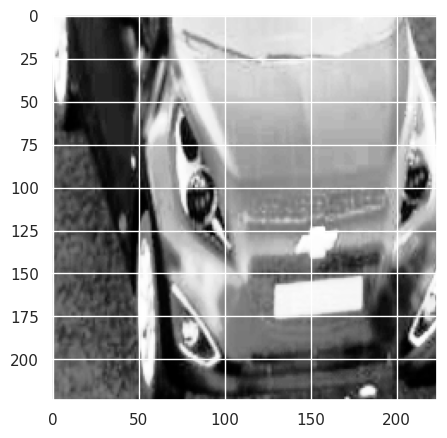

In [136]:
from torch.nn import functional as F


# test_list = sorted(glob("/data/dacon_cars/data/test_cars/*.png"))
test_list = sorted(glob("/data/dacon_cars/data/cars/2/*.png"))
# test_list = sorted(glob("/data/dacon_cars/data/test_cars/083935946_0.png"))
print(test_list[test_index])
print(test_index)
img = cv2.cvtColor(cv2.imread(test_list[test_index]), cv2.COLOR_BGR2RGB)
test_index += 1
with torch.no_grad():
    print(img.shape)
    img = img[5:-5, 5:-5]
    img = img[int(img.shape[0] / 2) :,]
    print(img.shape)
    test_img = test_transform(image=img)["image"]
    test_img = torch.Tensor(test_img).to(device, dtype=torch.float)
    test_img = torch.unsqueeze(test_img, 0)
    ensemble_probs = None
    for tta_model in model_list:
        probs = F.softmax(tta_model(test_img), dim=1)
        probs = np.round(probs.cpu().detach().numpy(), 3)

        if ensemble_probs is None:
            ensemble_probs = probs
        else:
            ensemble_probs = ensemble_probs + probs

    ensemble_probs = ensemble_probs / len(model_list)
    top1 = np.max(ensemble_probs)
    label = np.argmax(ensemble_probs)
    print(ensemble_probs)
    print(top1)
    print(label)
    # print(CFG.classes[label])
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor2im(test_img[0]))
    # f"{test_path}/test"

In [ ]:
bbox_submit = pd.read_csv("/data/dacon_cars/data/bbox_submit.csv")
filenames = sorted(os.listdir("/data/dacon_cars/data/test"))

total_list = []
for target in tqdm(iter(filenames)):
    car_info_df = bbox_submit[
        (bbox_submit["file_name"] == target)
        & ((bbox_submit["point3_x"] - bbox_submit["point1_x"]) <= 370)
        & ((bbox_submit["point3_y"] - bbox_submit["point1_y"]) <= 441)
    ]
    # print(one_test)

    infer_list = []
    for i, car_info in car_info_df.iterrows():
        file_name = car_info["file_name"]
        img = cv2.cvtColor(
            cv2.imread(f"/data/dacon_cars/data/test/{file_name}"),
            cv2.COLOR_BGR2RGB,
        )
        pt1x = int(np.round(car_info["point1_x"])) + 5
        pt1y = int(np.round(car_info["point1_y"])) + 5
        pt2x = int(np.round(car_info["point2_x"])) - 5
        pt2y = int(np.round(car_info["point2_y"])) + 5
        pt3x = int(np.round(car_info["point3_x"])) - 5
        pt3y = int(np.round(car_info["point3_y"])) - 5
        pt4x = int(np.round(car_info["point4_x"])) + 5
        pt4y = int(np.round(car_info["point4_y"])) - 5

        img = img[pt1y:pt3y, pt1x:pt3x]
        with torch.no_grad():
            img = test_transform(image=img)["image"]
            img = torch.Tensor(img).to(device, dtype=torch.float)
            img = torch.unsqueeze(img, 0)
            ensemble_probs = None
            for tta_model in model_list:
                probs = F.softmax(tta_model(img), dim=1)
                probs = np.round(probs.cpu().detach().numpy(), 3)

                if ensemble_probs is None:
                    ensemble_probs = probs
                else:
                    ensemble_probs = ensemble_probs + probs

            ensemble_probs = ensemble_probs / len(model_list)

        class_id = np.argmax(ensemble_probs)
        confidence = ensemble_probs[0][class_id]

        infer_list.append(
            [
                file_name,
                class_id,
                confidence,
                pt1x,
                pt1y,
                pt2x,
                pt2y,
                pt3x,
                pt3y,
                pt4x,
                pt4y,
            ]
        )

    infer_array = np.array(infer_list)
    try:
        max_confidence_list = infer_array[np.argmax(infer_array.T[2])].tolist()
    except:
        print(car_info)

    total_list.append(max_confidence_list)

In [ ]:
submit_df = pd.DataFrame(
    total_list,
    columns=[
        "file_name",
        "class_id",
        "confidence",
        "point1_x",
        "point1_y",
        "point2_x",
        "point2_y",
        "point3_x",
        "point3_y",
        "point4_x",
        "point4_y",
    ],
)
submit_df

In [ ]:
submit_df.to_csv("/data/submit.csv", index=False)

In [176]:
submit2_df = pd.read_csv("/data/submit3.csv")

In [174]:
submit2_df[
    (submit2_df["class_id"] == 4) & (submit2_df["confidence"] < 0.9)
].index.to_list()

[]

In [178]:
submit2_df.loc[
    submit2_df[
        (submit2_df["class_id"] == 4) & (submit2_df["confidence"] < 0.8)
    ].index.to_list(),
    "class_id",
] = 2

In [179]:
submit2_df.to_csv("/data/submit_test.csv")

In [ ]:
compare_df = pd.concat(
    [submit_df["file_name"], submit_df["class_id"], submit2_df["class_id"]],
    axis=1,
)

# compare_df = pd.merge(
#     submit_df[["file_name", "class_id"]],
#     submit2_df[["file_name", "class_id"]],
#     how="outer",
#     left_index=True,
#     right_index=True,
#     indicator=True,
# )

compare_df.columns = ["file_name", "class_id1", "class_id2"]
# print(compare_df)
print(compare_df)
compare_df.to_csv("/data/temp.csv")

In [ ]:
print(compare_df.compare(compare_df, align_axis=1))  # index